In [1]:
import pickle
import yaml
import pandas as pd
import pickle
import sys
import numpy as np

import matplotlib.pyplot as plot

In [2]:
def loadConfig():
    with open('./light_config.yaml', "r") as ymlfile: #GE, hulk, slowhttp, slowloris, heartbleed
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
import math

def calculateFalsePositives(agtIPList, agt_attacks, scoreDict, percentages, numNorm) :
    numNormal = numNorm
    numTotalIP = len(scoreDict)
    cutOff = []
    falsepositives = []
    
    for percent in percentages :
        cutOff.append(math.ceil(numTotalIP * percent))
    
    index = 0
    fp_count = 0 # add
    tp_count = 0 # add
    truepos = [] # add
    
    for (IP, IPD, score, label) in list(scoreDict.itertuples(index=False, name=None)):
        if IP + IPD in agtIPList: # add
            fp_count = fp_count + 1 # add
        if IP + IPD in agt_attacks:
            tp_count = tp_count + 1            
            
        index = index + 1
        if index in cutOff :
            falsepositives.append(fp_count/numNormal)
            truepos.append(tp_count / len(agt_attacks)) #len(agt_attacks)) # add
            
    return falsepositives, truepos
        
def plotAndSaveGraph(PQ, P, PQTil, classifier_rejectthres, fp_classifier, iter_classifier_one, iter_classifier, config, plt=False):
    percentages = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    plot.rcParams['figure.figsize'] = [9, 9]
    fig = plot.figure()
    ax = plot.subplot(111)
    # #ax.plot(percentages, old_graphScoreList, label = "Old P Over Q Scores")
    # #ax.plot(percentages, old_graphPList, label = "Old P Scores")
    ax.plot(percentages, percentages, linewidth=2, label = "Randomized Rejection")
    ax.plot(percentages, P, linewidth=2, linestyle='--', marker='o', markersize=9, label = "N Only")
    ax.plot(percentages, PQ, linewidth=2, linestyle=':', label = "N/D (ℓ=1)") #With Transfer")
    ax.plot(percentages, PQTil, linewidth=2, linestyle='-.', label = "N/D (ℓ=∞)") #Without Transfer") 
#     ax.plot(percentages, Qonline, label = "Online Q")
#     ax.plot(percentages, Qoffline, label = "Offline Q") 
    ax.plot(percentages, iter_classifier_one, linewidth=2, linestyle='--', label = "Iter. Classifier (ℓ=1)") #Without Transfer")
    ax.plot(percentages, iter_classifier, linewidth=2, linestyle='--', marker='s', markersize=9, label = "Iter. Classifier (ℓ=∞)") #Without Transfer")
#     ax.plot(percentages, fp_classifier, linewidth=2, label = "Classifier") #Without Transfer")
    ax.plot(classifier_rejectthres,fp_classifier,'rx',markersize=15,markeredgewidth=5, label = "Full Classifier") 
    
#     plot.xlabel('Rejection Threshold', fontsize=24)
#     plot.ylabel('False Reject Rates', fontsize=24)
#     plot.title("False Positive rates for " + config['metadata']['name'])
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=18)
    if plt:
        plot.savefig(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_FPGraph')


def calc_eval(fpr, tpr, agt_norm, agt_attk):
    fpr = np.array(fpr[1:])
    tpr = np.array(tpr)

    Total = len(agt_norm)+len(agt_attk) #len(userScoreP)
    TotalN = len(agt_norm)
    TotalP = Total-TotalN
    FP = fpr*TotalN
    TN = TotalN - FP
    TP = tpr*TotalP
    FN = TotalP-TP
    
    Accr = (TP+TN) / (TP+TN+FP+FN)
    FPR = FP / (FP + TN)
    Prec = TP / (TP + FP)
    Rec = TP / (TP + FN)
    F1 = 2 * ((Prec*Rec) / (Prec+Rec))

    return (Accr, FPR, Prec, Rec, F1)

### Test set

In [4]:
# #Load User Scores
userScoreP = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PScore', 'rb'))
userScoreP = userScoreP.sort_values(by = ['P'],ascending=True) # add

userScorePQ_online = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQonline_score', 'rb'))
userScorePQ_online = userScorePQ_online.sort_values(by = ['PoverQ_online'],ascending=True) # add 

userScorePQ_offline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQoffline_score', 'rb'))
userScorePQ_offline = userScorePQ_offline.sort_values(by = ['PoverQ_offline'],ascending=True) 

# userScoreQonline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'onlineQ', 'rb'))
# userScoreQonline = userScoreQonline.sort_values(by = ['QWithT'],ascending=True)

# userScoreQoffline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'offlineQ', 'rb'))
# userScoreQoffline = userScoreQoffline.sort_values(by = ['QWithoutT'],ascending=True)

print("Length of userScoreP: ", len(userScoreP))

Length of userScoreP:  16310


In [5]:
userScoreP

,Source IP,Dest IP,P,Attack
3941,41.171.21.15,71.126.222.64,-17.145144,1
9955,41.171.21.15,71.126.222.64,-17.144990,1
3296,41.171.21.15,71.126.222.64,-17.144990,1
11878,41.171.21.15,71.126.222.64,-17.144990,1
3747,41.171.21.15,71.126.222.64,-17.144990,1
...,...,...,...,...
6465,192.120.148.227,71.126.222.64,131.831109,0
4549,192.120.148.227,71.126.222.64,131.831109,0
6506,192.120.148.227,71.126.222.64,131.831109,0
5415,192.120.148.227,71.126.222.64,131.831109,0


In [5]:
import matplotlib.pyplot as plt
def showscore(scoretype, scores):
    fig = plt.figure(figsize=(7,5))
    print(len(scoretype[scores][scoretype['Attack'] == 0]))
    print(len(scoretype[scores][scoretype['Attack'] == 1]))
    plt.hist(scoretype[scores][scoretype['Attack'] == 0], bins = 10, alpha=0.5, label='victim') 
    plt.hist(scoretype[scores][scoretype['Attack'] == 1], bins = 10, alpha=0.5, label='attacker')
    plt.legend(loc='upper left')
    plt.show()
    
    return fig

3262
13048


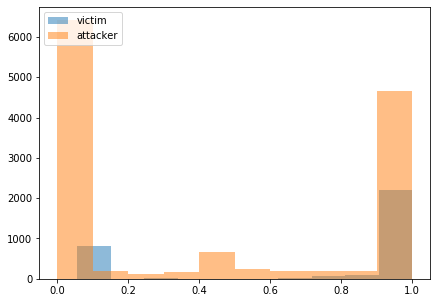

In [6]:
# add standardization
std_userScoreP = userScoreP
std_userScoreP['P'] = (std_userScoreP['P'] - std_userScoreP['P'].min(axis=0)) / (std_userScoreP['P'].max(axis=0) - std_userScoreP['P'].min(axis=0))

fig = showscore(userScoreP, 'P') # P scores

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_P_distr' + '.png')

3262
13048


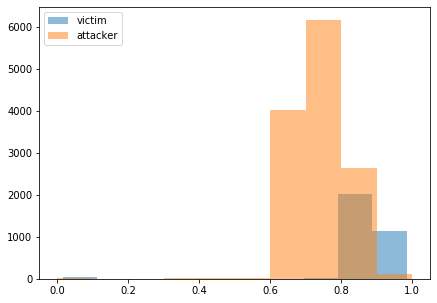

In [8]:
# add standardization
std_userScorePQ_online = userScorePQ_online
std_userScorePQ_online['PoverQ_online'] = (std_userScorePQ_online['PoverQ_online'] - std_userScorePQ_online['PoverQ_online'].min(axis=0)) / (std_userScorePQ_online['PoverQ_online'].max(axis=0) - std_userScorePQ_online['PoverQ_online'].min(axis=0))

fig = showscore(std_userScorePQ_online, 'PoverQ_online') # online Q

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PQonline_distr' + '.png')

3262
13048


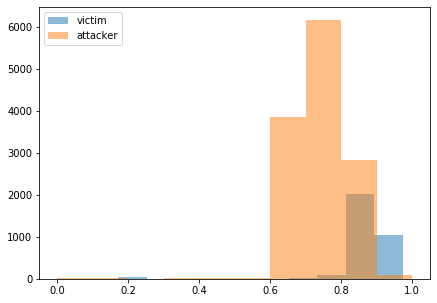

In [9]:
# add standardization
std_userScorePQ_offline = userScorePQ_offline
std_userScorePQ_offline['PoverQ_offline'] = (std_userScorePQ_offline['PoverQ_offline'] - std_userScorePQ_offline['PoverQ_offline'].min(axis=0)) / (std_userScorePQ_offline['PoverQ_offline'].max(axis=0) - std_userScorePQ_offline['PoverQ_offline'].min(axis=0))

fig = showscore(std_userScorePQ_offline, 'PoverQ_offline') # offline Q

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PQoffline_distr' + '.png')

In [6]:
agt_normals = []
agt_attacks = []

for (IP, IPD, score, label) in list(userScoreP.itertuples(index=False, name=None)):
#     if (IP != '172.16.0.1' and  IPD=='192.168.10.50') or IP == '192.168.10.50': 
    if label==0: 
        agt_normals.append(IP+IPD)
    else:
        agt_attacks.append(IP+IPD)

print("Length of Normal traffic: ", len(agt_normals))
print("Length of true attacks: ", len(agt_attacks))

#Plot some graphs
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

num = len(agt_normals)
print("Percent: ", num/len(userScoreP))

Length of Normal traffic:  3262
Length of true attacks:  13048
Percent:  0.2


In [8]:
classifier_rejectthres = 0.8 #0.5120
fp_classifier = 0.014714898835070508 #0.045370938074800735 #0.012568976088289392

fp_classifier

0.014714898835070508

In [16]:
# (ℓ = ∞)
# iter_classifier = [0,
#  0.004904966278356836,
#  0.012568976088289392, 
#  0.014101778050275904,
#  0.014101778050275904,
#  0.014101778050275904,
#  0.014101778050275904,
#  0.01594114040465972,
#  0.01624770079705702,
#  0.6220110361741263,
#  1.0]

## OLD
iter_classifier = [0,
 0.0269773145309626,
 0.028203556100551808,
 0.028203556100551808,
 0.028203556100551808,
 0.028203556100551808,
 0.028203556100551808,
 0.029429797670141016,
 0.029429797670141016,
 0.029429797670141016,
 1.0]

# [0,
#  0.0,
#  0.004598405885959534,
#  0.08277130594727161,
#  0.08798283261802575,
#  0.09809932556713673,
#  0.11036174126302882,
#  0.11710606989576947,
#  0.11925199264255058,
#  0.12078479460453709,
#  1.0]
iter_classifier

[0,
 0.0269773145309626,
 0.028203556100551808,
 0.028203556100551808,
 0.028203556100551808,
 0.028203556100551808,
 0.028203556100551808,
 0.029429797670141016,
 0.029429797670141016,
 0.029429797670141016,
 1.0]

In [18]:
# (ℓ = 1)
iter_classifier_one =  [0,
 0.002145922746781116,
 0.011036174126302882,
 0.011955855303494788,
 0.012262415695892091,
 0.020846106683016553,
 0.027896995708154508,
 0.02973635806253832,
 0.041385652973635806,
 0.08675659104843654,
 1.0]

## OLD
# iter_classifier_one =  [0,
#  0.05671367259350092,
#  0.09809932556713673,
#  0.1072961373390558,
#  0.10913549969343961,
#  0.1223175965665236,
#  0.1223175965665236,
#  0.1223175965665236,
#  0.1223175965665236,
#  0.1223175965665236,
#  1.0]

In [11]:
num = len(agt_normals)
print("Percent: ", num/len(userScoreP))

graphP, P_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScoreP, percentages, num)
graphPQ_online, onlinePQ_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_online, percentages, num)
graphPQ_offline, offlinePQ_tpr  = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_offline, percentages, num)
# graphQonline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQonline, percentages, num)
# graphQoffline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQoffline, percentages, num)   

graphP.insert(0, 0)
graphPQ_online.insert(0, 0)
graphPQ_offline.insert(0, 0)
# graphQonline.insert(0, 0)
# graphQoffline.insert(0, 0)

Percent:  0.2


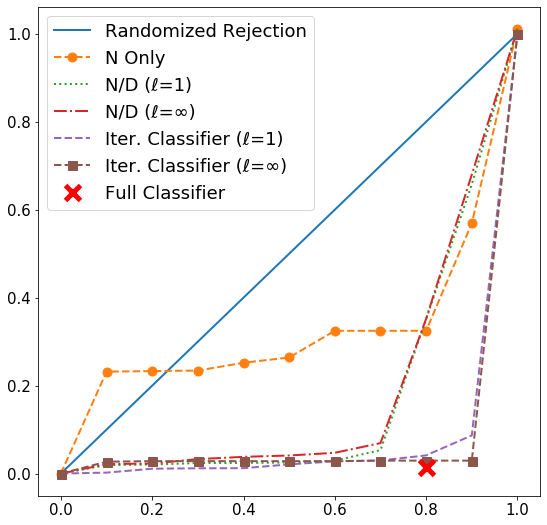

In [22]:
plotAndSaveGraph(graphPQ_online, graphP, graphPQ_offline, 
                 classifier_rejectthres, fp_classifier, iter_classifier_one, iter_classifier, config) #, plt=True)

### Calculate evaluation metrics 

In [14]:
P_metrics = np.array(np.transpose(calc_eval(graphP, P_tpr, agt_normals, agt_attacks)))
onlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_online, onlinePQ_tpr, agt_normals, agt_attacks)))
offlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_offline, offlinePQ_tpr, agt_normals, agt_attacks)))

P_metrics = pd.DataFrame(P_metrics, columns=['Accr_P', 'FPR_P', 'Prec_P', 'Rec_P', 'F1_P'])
onlinePQ_metrics = pd.DataFrame(onlinePQ_metrics, columns=['Accr_onPQ', 'FPR_onPQ', 
                                                           'Prec_onPQ', 'Rec_onPQ', 'F1_onPQ'])
offlinePQ_metrics = pd.DataFrame(offlinePQ_metrics, columns=['Accr_offPQ', 'FPR_offPQ', 
                                                             'Prec_offPQ', 'Rec_offPQ', 'F1_offPQ'])
df_FPresults = pd.concat([P_metrics,onlinePQ_metrics,offlinePQ_metrics],axis=1)

# df_FPresults.to_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + 
#                     "_evalresults.csv", index=False)

In [15]:
# Rows 3=0.4, 4=0.5, 5=0.6
df_FPresults#.iloc[4]

,Accr_P,FPR_P,Prec_P,Rec_P,F1_P,Accr_onPQ,FPR_onPQ,Prec_onPQ,Rec_onPQ,F1_onPQ,Accr_offPQ,FPR_offPQ,Prec_offPQ,Rec_offPQ,F1_offPQ
0,0.207725,0.231760,0.538462,0.067597,0.120114,0.296137,0.019313,0.962810,0.125000,0.221273,0.295279,0.021459,0.958678,0.124464,0.220323
1,0.307480,0.232986,0.767797,0.192597,0.307947,0.395892,0.020540,0.979874,0.250000,0.398364,0.394911,0.022992,0.977471,0.249387,0.397387
2,0.407235,0.234212,0.844336,0.317597,0.461573,0.494788,0.023912,0.984287,0.374464,0.542527,0.491232,0.032802,0.978445,0.372241,0.539307
3,0.503617,0.251993,0.875379,0.442520,0.587864,0.594727,0.024218,0.988023,0.499464,0.663510,0.589209,0.038013,0.981201,0.496015,0.658929
4,0.600920,0.263948,0.895775,0.567137,0.694542,0.694359,0.025138,0.990033,0.624234,0.765687,0.687983,0.041079,0.983712,0.620248,0.760799
5,0.676824,0.324647,0.892976,0.677192,0.770257,0.792643,0.029430,0.990262,0.748161,0.852353,0.785530,0.047210,0.984378,0.743716,0.847289
6,0.776824,0.324647,0.908121,0.802192,0.851876,0.884733,0.053342,0.984891,0.869252,0.923465,0.877192,0.069283,0.980343,0.863811,0.918395
7,0.876824,0.324647,0.919511,0.927192,0.923335,0.889577,0.351012,0.915417,0.949724,0.932255,0.889148,0.351931,0.915189,0.949418,0.931989
8,0.900552,0.568976,0.877395,1.017934,0.942454,0.899448,0.657572,0.863358,1.038703,0.942949,0.890435,0.679951,0.858699,1.033032,0.937833
9,0.857940,1.011343,0.809625,1.075261,0.923725,0.857940,1.011343,0.809625,1.075261,0.923725,0.857940,1.011343,0.809625,1.075261,0.923725


In [16]:
# reject 50%
df_FPresults.iloc[4]

Accr_P        0.600920
FPR_P         0.263948
Prec_P        0.895775
Rec_P         0.567137
F1_P          0.694542
Accr_onPQ     0.694359
FPR_onPQ      0.025138
Prec_onPQ     0.990033
Rec_onPQ      0.624234
F1_onPQ       0.765687
Accr_offPQ    0.687983
FPR_offPQ     0.041079
Prec_offPQ    0.983712
Rec_offPQ     0.620248
F1_offPQ      0.760799
Name: 4, dtype: float64